In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from soliton import ideal_soliton, robust_soliton

In [2]:
def xor(s1, s2):
    '''
    perform component-wise xor
    '''
    assert len(s1) == len(s2), 'cannot xor if unequal size'
    return ''.join(str(int(a)^int(b)) for a,b in zip(s1,s2))

class Packet():
    '''
    Structure to encapsulate information about each packet
    :param data - store the xor'd information
    :param degree - number of input symbols xor'd together
    :param num_blocks - original total number of input symbols
    :param seed - used for recovering indices
    '''
    def __init__(self, data, degree, num_blocks, seed):
        self.data = data
        self.degree = degree
        self.num_blocks = num_blocks
        self.seed = seed
    
    def recover_source(self):
        '''
        Using degree and random seed, recover the indices of blocks that
        were xor'd together to generate data
        '''
        random.seed(self.seed)
        indices = random.sample(range(self.num_blocks), self.degree)
        self.indices = indices
        self.neighbors = list(indices)
    
    def __str__(self):
        ind = self.indices if hasattr(self, 'indices') else None
        return 'packet object data: {} \n degree: {} \n num blocks: '.format(self.data, self.degree) \
            + '{} \n seed: {} \n indices: {} \n neighbors: {}'.format(self.num_blocks, \
                self.seed, ind, self.neighbors)

class Encoder():
    def create_blocks(self, data, blk_sz, pad_with=0):
        '''
        divide data into blocks of tunable size
        :param blk_sz - desired block size
        :param pad_with - if size of data is not evenly divisible, ensure that all
            blocks are of the same size
        '''
        self.data = data
        blocks = [self.data[i:i + blk_sz] for i in range(0, len(self.data), blk_sz)]
        blocks[-1] += '0' * (blk_sz - len(blocks[-1]))
        self.blocks = blocks
    
    def encode(self, seed, soliton, M = None, d = None, num_to_transmit = float('inf')):
        '''
        generator to indefinitely produce xor'd Packets
        :param seed - random seed for recovering indices
        :param soliton - desired degree distribution
        :param M, d - parameters for robust soliton
        :num_to_transmit - number of Packets to generate
        NOTE: must call create_blocks before calling this function
        '''
        assert hasattr(self, 'blocks'), 'Must call create_blocks to initialize'

        counter = 0
        num_blocks = len(self.blocks)
        while counter < num_to_transmit:
            # choose a degree based on the given soliton distribution
            degree = np.random.choice(range(1, num_blocks + 1), p=soliton(num_blocks, M=M, d=d))
            
            # seed so that we can recover the source block indices
            random.seed(seed)
            indices = random.sample(range(num_blocks), degree)
            
            # XOR all blocks
            block = self.blocks[indices[0]]
            for b in indices[1:]:
                block = xor(block, self.blocks[b])

            yield Packet(block, degree, num_blocks, seed)
            # do not duplicate seeds
            seed += 1
            counter += 1

class Decoder():
    def __init__(self):
        self.received = [] # queue for unsolved packets
        self.belief = [None] # list of original input symbols
        self.num_blocks = None # number of input symbols
        self.deg_one_syms = [] # queue of solved packets
        self.num_packets = 0
    
    def update_belief(self, packet):
        # first packet received
        if self.num_blocks is None:
            self.num_blocks = packet.num_blocks
            self.belief = [None] * self.num_blocks
        packet.recover_source()
        self.num_packets += 1
        if not any(elem is None for elem in self.belief): return # finished!!
        # preprocess the packet
        for n in packet.neighbors:
            if self.belief[n] is not None:
                packet.data = xor(packet.data, self.belief[n])
                packet.neighbors.remove(n)
        # potential for ripples
        if len(packet.neighbors) == 1:
            self.deg_one_syms.append(packet)
            self.ripple()
        else:
            self.received.append(packet)
    
    def ripple(self):
        if len(self.deg_one_syms) == 0: return
        symbol = self.deg_one_syms.pop(0)
        
        index = symbol.neighbors[0]
        self.belief[index] = symbol.data
        
        for r in self.received:
            if index in r.neighbors:
                r.data = xor(r.data, symbol.data)
                r.neighbors.remove(index)
                if len(r.neighbors) == 1:
                    self.deg_one_syms.append(r)
                    self.received.remove(r)
        self.ripple()

In [3]:
num_packets = 1000
packet_sz = 20

In [9]:
e = Encoder()
data = ''.join([str(random.randint(0, 1)) for _ in range(num_packets * packet_sz)])
e.create_blocks(data, packet_sz)
enc = e.encode(0, robust_soliton, M = 485, d = 2)

# xes = [next(enc) for _ in range(int(num_packets * 1.25))]

d = Decoder()
while any(elem is None for elem in d.belief):
    d.update_belief(next(enc))
assert all(x is not None for x in d.belief), 'has not successfully reconstructed message'
# for x in xes:
#     d.update_belief(x)

out_data = ''.join(d.belief)
in_data = e.data
assert out_data == in_data, 'produced incorrect beliefs'

In [14]:
overall = []

for _ in range(5):
    packets_required = []

    e = Encoder()
    data = ''.join([str(random.randint(0, 1)) for _ in range(num_packets * packet_sz)])
    e.create_blocks(data, packet_sz)
    enc = e.encode(0, robust_soliton, M = 485, d = 2)

    for _ in range(5):
        # keep getting until all good
        d = Decoder()
        while any(elem is None for elem in d.belief):
            d.update_belief(next(enc))
        assert all(x is not None for x in d.belief), 'has not successfully reconstructed message'
        out_data = ''.join(d.belief)
        in_data = e.data
        assert out_data == in_data, 'produced incorrect beliefs'
        packets_required.append(d.num_packets)

    overall.append(packets_required)

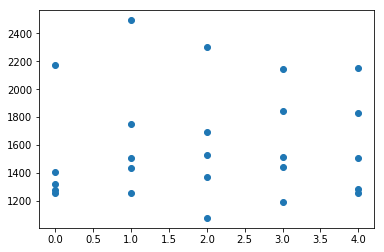

In [15]:
overall = np.array(overall)
x, y = [], []
for r in range(overall.shape[0]):
    for c in range(overall.shape[1]):
        x.append(r)
        y.append(overall[r,c])
plt.scatter(x,y)
plt.show()

In [13]:
'''run this cell to validate degree distribution'''
from collections import Counter

degs = [x.degree for x in xes]
c = Counter(degs)
degss = [v for _,v in sorted(c.items())]

f, ax = plt.subplots(ncols = 2)
ax[0].plot(degss)
ax[1].plot(robust_soliton(1000, M = 485, d = 2))

NameError: name 'xes' is not defined

In [185]:
all(x > 0 for x in robust_soliton(5000, M = 485, d = 2))

True